In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

2024-03-28 10:08:14.511346: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-28 10:08:14.877721: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 10:08:14.877766: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 10:08:14.951877: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-28 10:08:15.106977: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-28 10:08:15.109285: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)

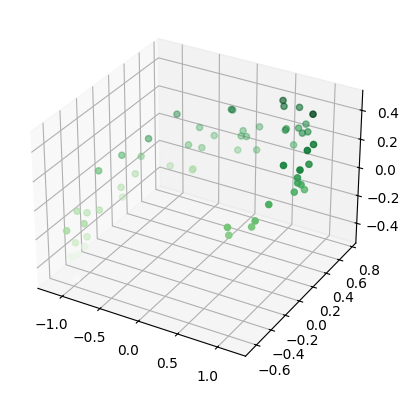

In [3]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X_train[:,0], X_train[:, 1], X_train[:, 2], c=X_train[:, 2], cmap='Greens')

In [4]:
encoder = keras.models.Sequential(keras.layers.Dense(2, input_shape=[3]))
decoder = keras.models.Sequential(keras.layers.Dense(3, input_shape=[2]))
autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=1.5))

autoencoder.fit(X_train, X_train, epochs=30)

2024-03-28 10:08:18.595339: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-28 10:08:18.780720: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/30
2/2 [==============================] - 0s 5ms/step - loss: 0.9945
Epoch 2/30
2/2 [==============================] - 0s 3ms/step - loss: 0.9287
Epoch 3/30
2/2 [==============================] - 0s 4ms/step - loss: 0.8681
Epoch 4/30
2/2 [==============================] - 0s 4ms/step - loss: 0.8141
Epoch 5/30
2/2 [==============================] - 0s 3ms/step - loss: 0.7652
Epoch 6/30
2/2 [==============================] - 0s 3ms/step - loss: 0.7211
Epoch 7/30
2/2 [==============================] - 0s 3ms/step - loss: 0.6809
Epoch 8/30
2/2 [==============================] - 0s 3ms/step - loss: 0.6443
Epoch 9/30
2/2 [==============================] - 0s 3ms/step - loss: 0.6111
Epoch 10/30
2/2 [==============================] - 0s 4ms/step - loss: 0.5801
Epoch 11/30
2/2 [==============================] - 0s 3ms/step - loss: 0.5519
Epoch 12/30
2/2 [==============================] - 0s 4ms/step - loss: 0.5259
Epoch 13/30
2/2 [==============================] - 0s 3ms/step - loss: 0.

In [5]:
codings = encoder.predict(X_train)

2/2 [==============================] - 0s 2ms/step


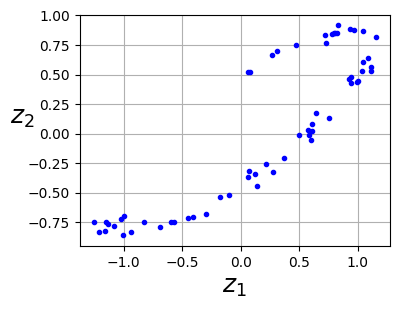

In [6]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.show()

In [7]:
from sklearn.model_selection import train_test_split

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2)

X_train = X_train.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_val = X_val.astype(np.float32) / 255

In [8]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [9]:
stacked_encoder = keras.models.Sequential([keras.layers.Flatten(input_shape=[28,28]),
                                          keras.layers.Dense(100, activation='selu'),
                                          keras.layers.Dense(30, activation='selu')])

stacked_decoder = keras.models.Sequential([keras.layers.Dense(100, activation='selu', input_shape=[30]),
                                          keras.layers.Dense(784, activation='sigmoid'),
                                          keras.layers.Reshape([28, 28])])

stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])

In [10]:
history = stacked_ae.fit(X_train, X_train, epochs=30, validation_data=(X_val, X_val))

Epoch 1/30
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3412 - rounded_accuracy: 0.8840 - val_loss: 0.3126 - val_rounded_accuracy: 0.9107
Epoch 2/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3077 - rounded_accuracy: 0.9132 - val_loss: 0.3031 - val_rounded_accuracy: 0.9155
Epoch 3/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3009 - rounded_accuracy: 0.9194 - val_loss: 0.2998 - val_rounded_accuracy: 0.9167
Epoch 4/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2965 - rounded_accuracy: 0.9233 - val_loss: 0.2966 - val_rounded_accuracy: 0.9229
Epoch 5/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2932 - rounded_accuracy: 0.9264 - val_loss: 0.2942 - val_rounded_accuracy: 0.9272
Epoch 6/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2909 - rounded_accuracy: 0.9285 - val_loss: 0.2916 - val_rounded_accuracy: 0.9249
Epoch 7/30
1500/1500 [==================

In [11]:
def plot_image(image):
    plt.imshow(image, cmap='binary')
    plt.axis('off')

In [12]:
def show_reconstructions(model, images=X_val, n_images=5):
    true_images = images[:n_images]
    recon_images = model.predict(true_images)

    figure = plt.figure(figsize=(8.6, 6))
    for i in range(n_images):
        figure.add_subplot(2, n_images, i + 1)
        plot_image(true_images[i])
        figure.add_subplot(2, n_images, i + 1 + n_images)
        plot_image(recon_images[i])

In [13]:
# show_reconstructions(stacked_ae)

In [14]:
from sklearn.manifold import TSNE

X_val_compressed = stacked_encoder.predict(X_val)
tsne = TSNE()
X_val_2D = tsne.fit_transform(X_val_compressed)

375/375 [==============================] - 0s 875us/step


In [15]:
# plt.scatter(X_val_2D[:,0], X_val_2D[:, 1], c=y_val, s=10, cmap='tab10')

### Tying Weights

In [16]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.dense = dense
        self.activation = keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.biases = self.add_weight(name='bias', shape=[self.dense.input_shape[-1]], initializer="zeros")        
        super().build(batch_input_shape)
        
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)
        

In [17]:
dense_1 = keras.layers.Dense(100, activation='selu')
dense_2 = keras.layers.Dense(30, activation='selu')

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation='selu'),
    DenseTranspose(dense_1, activation='sigmoid'),
    keras.layers.Reshape([28,28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])
tied_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=10, validation_data=(X_val, X_val))

Epoch 1/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3305 - rounded_accuracy: 0.8927 - val_loss: 0.3027 - val_rounded_accuracy: 0.9198
Epoch 2/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2996 - rounded_accuracy: 0.9204 - val_loss: 0.3011 - val_rounded_accuracy: 0.9127
Epoch 3/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2936 - rounded_accuracy: 0.9261 - val_loss: 0.2910 - val_rounded_accuracy: 0.9292
Epoch 4/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2903 - rounded_accuracy: 0.9291 - val_loss: 0.2894 - val_rounded_accuracy: 0.9293
Epoch 5/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2883 - rounded_accuracy: 0.9309 - val_loss: 0.2867 - val_rounded_accuracy: 0.9321
Epoch 6/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2869 - rounded_accuracy: 0.9321 - val_loss: 0.2860 - val_rounded_accuracy: 0.9319
Epoch 7/10
1500/1500 [==================

In [18]:
# show_reconstructions(tied_ae)
# plt.show()

### CNN Autoencoder

In [19]:
conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28,28,1], input_shape=[28,28]),
    keras.layers.Conv2D(16, kernel_size=3, padding='same', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding='same', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2)
])

conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='valid', activation='selu', input_shape=[3,3,64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding='same', activation='selu'),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding='same', activation='sigmoid'),
    keras.layers.Reshape([28,28])
])

In [20]:
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])
conv_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1.0), metrics=[rounded_accuracy])

In [21]:
history = conv_ae.fit(X_train, X_train, epochs=5, validation_data=[X_val, X_val])

Epoch 1/5
1500/1500 [==============================] - 19s 12ms/step - loss: 0.3043 - rounded_accuracy: 0.9167 - val_loss: 0.2791 - val_rounded_accuracy: 0.9404
Epoch 2/5
1500/1500 [==============================] - 18s 12ms/step - loss: 0.2766 - rounded_accuracy: 0.9405 - val_loss: 0.2746 - val_rounded_accuracy: 0.9419
Epoch 3/5
1500/1500 [==============================] - 18s 12ms/step - loss: 0.2719 - rounded_accuracy: 0.9452 - val_loss: 0.2711 - val_rounded_accuracy: 0.9465
Epoch 4/5
1500/1500 [==============================] - 18s 12ms/step - loss: 0.2692 - rounded_accuracy: 0.9479 - val_loss: 0.2672 - val_rounded_accuracy: 0.9508
Epoch 5/5
1500/1500 [==============================] - 18s 12ms/step - loss: 0.2674 - rounded_accuracy: 0.9497 - val_loss: 0.2665 - val_rounded_accuracy: 0.9516


1/1 [==============================] - 0s 85ms/step


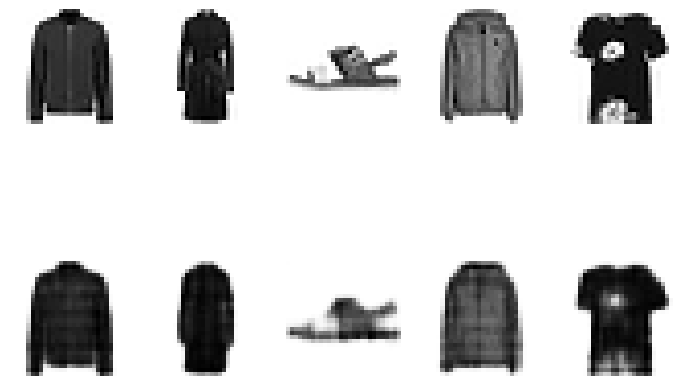

In [22]:
show_reconstructions(conv_ae)

In [23]:
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)         

### RNN Autoencoder

In [24]:
rnn_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28,28]),
    keras.layers.LSTM(30)
])
rnn_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation='sigmoid'))
])

In [25]:
rnn_ae = keras.models.Sequential([rnn_encoder, rnn_decoder])


### Denoising Autoencoder

In [26]:
denoise_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(30, activation='selu')
])
denoise_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[30]),
    keras.layers.Dense(28*28, activation='sigmoid'), 
    keras.layers.Reshape([28,28])
])

In [27]:
denoise_ae = keras.models.Sequential([denoise_encoder, denoise_decoder])
denoise_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1.0), metrics=[rounded_accuracy])
history = denoise_ae.fit(X_train, X_train, epochs=10, validation_data=(X_val, X_val))

Epoch 1/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3584 - rounded_accuracy: 0.8696 - val_loss: 0.3184 - val_rounded_accuracy: 0.9052
Epoch 2/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3193 - rounded_accuracy: 0.9023 - val_loss: 0.3114 - val_rounded_accuracy: 0.9079
Epoch 3/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3133 - rounded_accuracy: 0.9070 - val_loss: 0.3065 - val_rounded_accuracy: 0.9125
Epoch 4/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3094 - rounded_accuracy: 0.9104 - val_loss: 0.3034 - val_rounded_accuracy: 0.9147
Epoch 5/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3068 - rounded_accuracy: 0.9125 - val_loss: 0.3004 - val_rounded_accuracy: 0.9210
Epoch 6/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3049 - rounded_accuracy: 0.9141 - val_loss: 0.2993 - val_rounded_accuracy: 0.9217
Epoch 7/10
1500/1500 [==================

In [28]:
# show_reconstructions(denoise_ae)

(-0.5, 27.5, 27.5, -0.5)

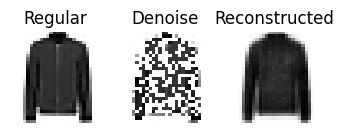

In [29]:
dropout = keras.layers.Dropout(0.5)
figure = plt.figure(figsize=[4,3])
figure.add_subplot(1,3,1)
plt.imshow(X_val[0], cmap='binary')
plt.title('Regular')
plt.axis('off')
figure.add_subplot(1,3,2)
plt.imshow(dropout(X_val[0], training=True), cmap='binary')
plt.title('Denoise')
plt.axis('off')
figure.add_subplot(1,3,3)
plt.imshow(denoise_ae(dropout(X_val))[0], cmap='binary')
plt.title('Reconstructed')
plt.axis('off')

### Sparse Autoencoder

In [30]:
sparse_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(300, activation='sigmoid', activity_regularizer=keras.regularizers.l1(1e-3))
])

sparse_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(28 * 28, activation='sigmoid'),
    keras.layers.Reshape([28,28])
])

In [31]:
sparse_ae = keras.models.Sequential([sparse_encoder, sparse_decoder])
sparse_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1.0), metrics=[rounded_accuracy])
history = sparse_ae.fit(X_train, X_train, epochs=20, validation_data=(X_val, X_val))

Epoch 1/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.4375 - rounded_accuracy: 0.8083 - val_loss: 0.3802 - val_rounded_accuracy: 0.8584
Epoch 2/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3726 - rounded_accuracy: 0.8656 - val_loss: 0.3654 - val_rounded_accuracy: 0.8710
Epoch 3/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3588 - rounded_accuracy: 0.8768 - val_loss: 0.3521 - val_rounded_accuracy: 0.8816
Epoch 4/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3475 - rounded_accuracy: 0.8848 - val_loss: 0.3429 - val_rounded_accuracy: 0.8891
Epoch 5/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3401 - rounded_accuracy: 0.8901 - val_loss: 0.3375 - val_rounded_accuracy: 0.8899
Epoch 6/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3341 - rounded_accuracy: 0.8952 - val_loss: 0.3312 - val_rounded_accuracy: 0.8975
Epoch 7/20
1500/1500 [==================

### Variational Autoencoders

In [32]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_sigma = inputs
        epsilon = keras.backend.random_normal(tf.shape(z_sigma))
        return z_mean + tf.math.exp(z_sigma / 2) * epsilon

In [38]:
latent_dim = 10

inputs = keras.layers.Input(shape=[28,28])
flat = keras.layers.Flatten()(inputs)
h1 = keras.layers.Dense(150, activation='selu')(flat)
h2 = keras.layers.Dense(100, activation='selu')(h1)
mean = keras.layers.Dense(latent_dim)(h2)
sigma = keras.layers.Dense(latent_dim)(h2)
codings = Sampling()([mean, sigma])

variational_encoder = keras.models.Model(inputs=[inputs], outputs=[mean, sigma, codings])
variational_encoder.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 28, 28)]             0         []                            
                                                                                                  
 flatten_6 (Flatten)         (None, 784)                  0         ['input_6[0][0]']             
                                                                                                  
 dense_28 (Dense)            (None, 150)                  117750    ['flatten_6[0][0]']           
                                                                                                  
 dense_29 (Dense)            (None, 100)                  15100     ['dense_28[0][0]']            
                                                                                            

In [39]:
d_inputs = keras.layers.Input(shape=[10])
d_h1 = keras.layers.Dense(100, activation='selu')(d_inputs)
d_h2 = keras.layers.Dense(150, activation='selu')(d_h1)
d_out = keras.layers.Dense(28 * 28, activation='sigmoid')(d_h2)
outputs = keras.layers.Reshape([28,28])(d_out)

variational_decoder = keras.models.Model(inputs=[d_inputs], outputs=[outputs])
variational_decoder.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_32 (Dense)            (None, 100)               1100      
                                                                 
 dense_33 (Dense)            (None, 150)               15150     
                                                                 
 dense_34 (Dense)            (None, 784)               118384    
                                                                 
 reshape_7 (Reshape)         (None, 28, 28)            0         
                                                                 
Total params: 134634 (525.91 KB)
Trainable params: 134634 (525.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
_, _, codings = variational_encoder(inputs)
reconstruction = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[codings], outputs=[reconstruction])
variational_ae.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 10)]              0         
                                                                 
 model_1 (Functional)        (None, 28, 28)            134634    
                                                                 
Total params: 134634 (525.91 KB)
Trainable params: 134634 (525.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [41]:
variance = 0.24
print(np.exp(np.log(0.24)))
print(np.log(0.24))

0.24
-1.4271163556401458
